**Add your LiU-ID here:**
* arviv790
* valpa404

### **0. Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu (if you are using Jupyter lab) and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells. The same options in VSCode are available in the menu at the top of the notebook.

### **0.5 Setup**

In [3]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotTrainingProgress, plotResultsDots, plotConfusionMatrixOCR
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Two-layer neural network**

You will now implement the same function you did for the single-layer network, but this time for a two-layer network. This means that you will keep track of two weight matrices `W1` and `W2`, two bias vectors `B1` and `B2`. The structure of the code is otherwise still the same, with a `forward`, `backward`, and `update` function.

#### **1.1 Implementing the forward pass**

This implementation will look similar to the single-layer code, but note that you should also return the intemediate variable `U`, which is the output of the hidden layer after passing throught the activation function. This will be used in the backward pass.

In [20]:
def forward(X, W1, B1, W2, B2, useTanhOutput=False):
    """Forward pass of two layer network

    Args:
        X (array): Input samples.
        W1 (array): First layer neural network weights.
        B1 (array): First layer neural network biases.
        W2 (array): Second layer neural network weights.
        B2 (array): Second layer neural network biases.

    Optional Args:
        useTanhOutput (bool) (optional):
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
            You are not required to implement this, but it may be useful for faster training.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
        U (array): Output of hidden layer.
    """

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    U = np.tanh(X @ W1 + B1) #Hidden layer
    Y = U @ W2 + B2 #Output layer

    if useTanhOutput:
        Y = np.tanh(Y)
    
    # ============================================
    
    # Calculate labels
    L = Y.argmax(axis=1)

    return Y, L, U

#### **1.2 Implementing the backward pass**

In [16]:
def backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        X (array): Training samples.
        U (array): Intermediate outputs of the hidden layer.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool): (optional)
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
    
    Note:
        The 'useTanhOutput' parameter only controls the activation on the
        output layer, not the hidden layer. The hidden layer must always use
        a nonlinear activation function (e.g. tanh) to work properly.
        
    Returns:
        GradW1 (array): Gradients with respect to W1
        GradB1 (array): Gradients with respect to B1
        GradW2 (array): Gradients with respect to W2
        GradB2 (array): Gradients with respect to B2
    """
    
    N  = Y.shape[0]
    NC = Y.shape[1]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # dL/dY
    dY = (2 / N) *(Y - D)
    
    if useTanhOutput:
        dZ2 = dY * (1 - Y**2)      # since Y = tanh(Z2)
    else:
        dZ2 = dY                   # since Y = Z2

    # Gradients for layer 2
    GradW2 = U.T @ dZ2
    GradB2 = np.sum(dZ2, axis=0, keepdims=True)

    # Backprop into hidden layer
    dU  = dZ2 @ W2.T
    dZ1 = dU * (1 - U**2)          # hidden always uses tanh

    # Gradients for layer 1
    GradW1 = X.T @ dZ1
    GradB1 = np.sum(dZ1, axis=0, keepdims=True)
    
    # ============================================
    
    return GradW1, GradB1, GradW2, GradB2

#### **1.3 Implementing the weight update**

In [17]:
def update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params):
    """Update weights and biases using computed gradients.

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        
        GradW1 (array): Gradients with respect to W1.
        GradB1 (array): Gradients with respect to B1.
        GradW2 (array): Gradients with respect to W2.
        GradB2 (array): Gradients with respect to B2.
        
        params (dict):
            - learningRate: Scale factor for update step.
            - momentum: Scale factor for momentum update (optional).
        
    Returns:
        W1 (array): Updated layer 1 weights.
        B1 (array): Updated layer 1 biases.
        W2 (array): Updated layer 2 weights.
        B2 (array): Updated layer 2 biases.
    """
    
    LR = params["learningRate"]
    
    # For optional task on momentum
    # Uncomment this is you are working on the optional task on momentum.
    # M = params.get("momentum", 0.0)
    # PrevGradW1 = params.get("PrevGradW1", 0.0)
    # PrevGradB1 = params.get("PrevGradB1", 0.0)
    # PrevGradW2 = params.get("PrevGradW2", 0.0)
    # PrevGradB2 = params.get("PrevGradB2", 0.0)
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Update weights
    W1 = W1 - LR * GradW1
    B1 = B1 - LR * GradB1
    W2 = W2 - LR * GradW2
    B2 = B2 - LR * GradB2
    
    # Uncomment this is you are working on the optional task on momentum.
    # params["PrevGradW1"] = ???
    # params["PrevGradB1"] = ???
    # params["PrevGradW2"] = ???
    # params["PrevGradB2"] = ???

    # ============================================
    
    return W1, B1, W2, B2
    

#### **1.4 Validation on a simple test case**

We now perform the same validation with a small test case as in the single-layer network.

In [21]:
def trainingStep(X, D, W1, B1, W2, B2, learningRate, useTanhOutput=False):
    """
    Perform one training step of the single layer neural network.

    Args:
        X (array): Input samples.
        D (array): Target outputs.
        W (array): Current weights of the network.
        B (array): Current biases of the network.
        learningRate (float): Learning rate for weight updates.
        useTanhOutput (bool) (optional):
    """

    # Perform forward and backward passes, then update weights
    Y, L, U = forward(X, W1, B1, W2, B2, useTanhOutput)
    dW1, dB1, dW2, dB2 = backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput)
    W1_new, B1_new, W2_new, B2_new = update(W1, B1, W2, B2, dW1, dB1, dW2, dB2, {"learningRate": learningRate})

    return Y, L, dW1, dB1, dW2, dB2, W1_new, B1_new, W2_new, B2_new

In [22]:
from utils import checkExpectedResults

# Random test case data and parameters
X  = np.array( [[0.38, 0.31], [0.08, 0.15], [0.36, 0.66]] )
D  = np.array( [[1, 0], [0, 1], [1, 0]] )
W1 = np.array( [[0.82, 0.38, 0.92], [0.57, 0.35, 0.84]] )
B1 = np.array( [[0.12, 0.36, 0.27]] )
W2 = np.array( [[0.72, 0.72], [0.27, 0.79], [0.52, 0.76]] )
B2 = np.array( [[0.57, 0.16]] )
learningRate = 0.88


# Test case 1: No activation function
print("------------------------------------------\nTest case 1: No activation function\n")
Y, L, dW1, dB1, dW2, dB2, W1_new, B1_new, W2_new, B2_new = trainingStep(X, D, W1, B1, W2, B2, learningRate, useTanhOutput=False)

Yexp = np.array( [[1.48, 1.52], [1.1, 1.01], [1.64, 1.75]] )
Lexp = np.array( [1, 0, 1] )
dW1exp = np.array( [[0.53, 0.48, 0.33], [0.71, 0.64, 0.43]] )
dB1exp = np.array( [[1.82, 1.43, 1.15]] )
dW2exp = np.array( [[0.65, 1.32], [0.74, 1.28], [0.89, 1.67]] )
dB2exp = np.array( [[1.48, 2.19]] )
W1_new_exp = np.array( [[0.35, -0.04, 0.63], [-0.06, -0.21, 0.46]] )
B1_new_exp = np.array( [[-1.48, -0.89, -0.74]] )
W2_new_exp = np.array( [[0.15, -0.44], [-0.38, -0.34], [-0.27, -0.71]] )
B2_new_exp = np.array( [[-0.73, -1.76]] )

checkExpectedResults(Y, L, [dW1, dW2], [dB1, dB2], [W1_new, W2_new], [B1_new, B2_new], 
                     Yexp=Yexp, Lexp=Lexp, dWexp=[dW1exp, dW2exp], dBexp=[dB1exp, dB2exp],
                     W_new_exp=[W1_new_exp, W2_new_exp], B_new_exp=[B1_new_exp, B2_new_exp],
                     decimals=2)

# Test case 2: With tanh activation function (same data as test case 1)
print("\n----------------------------------------\nTest case 2: With tanh output activation function\n")
Y, L, dW1, dB1, dW2, dB2, W1_new, B1_new, W2_new, B2_new = trainingStep(X, D, W1, B1, W2, B2, learningRate, useTanhOutput=True)

Yexp = np.array( [[0.9, 0.91], [0.8, 0.77], [0.93, 0.94]] )
Lexp = np.array( [1, 0, 1] )
dW1exp = np.array( [[0.03, 0.03, 0.02], [0.04, 0.04, 0.03]] )
dB1exp = np.array( [[0.16, 0.09, 0.09]] )
dW2exp = np.array( [[0.04, 0.09], [0.07, 0.08], [0.07, 0.11]] )
dB2exp = np.array( [[0.17, 0.11]] )
W1_new_exp = np.array( [[0.79, 0.35, 0.9], [0.53, 0.32, 0.81]] )
B1_new_exp = np.array( [[-0.02, 0.28, 0.19]] )
W2_new_exp = np.array( [[0.69, 0.64], [0.21, 0.72], [0.46, 0.67]] )
B2_new_exp = np.array( [[0.42, 0.06]] )

checkExpectedResults(Y, L, [dW1, dW2], [dB1, dB2], [W1_new, W2_new], [B1_new, B2_new], 
                     Yexp=Yexp, Lexp=Lexp, dWexp=[dW1exp, dW2exp], dBexp=[dB1exp, dB2exp],
                     W_new_exp=[W1_new_exp, W2_new_exp], B_new_exp=[B1_new_exp, B2_new_exp],
                     decimals=2)

------------------------------------------
Test case 1: No activation function

Forward pass outputs Y are correct.
Predicted labels L are correct.
Gradients dW1 are correct.
Gradients dB1 are correct.
Gradients dW2 are correct.
Gradients dB2 are correct.
Updated weights W1_new are correct.
Updated biases B1_new are correct.
Updated weights W2_new are correct.
Updated biases B2_new are correct.

----------------------------------------
Test case 2: With tanh output activation function

Forward pass outputs Y are correct.
Predicted labels L are correct.
Gradients dW1 are correct.
Gradients dB1 are correct.
Gradients dW2 are correct.
Gradients dB2 are correct.
Updated weights W1_new are correct.
Updated biases B1_new are correct.
Updated weights W2_new are correct.
Updated biases B2_new are correct.


#### **1.4 The training function**

In [23]:
def trainTwoLayer(XTrain, DTrain, XTest, DTest, W1_0, B1_0, W2_0, B2_0, params):
    """Trains a two-layer network

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training target outputs.
        XTest (array): Test samples.
        DTest (array): Test target outputs.

        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.

        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.
            useTanhOutput (bool, optional): Determines if output layer should use tanh activation.
            momentum (float, optional): Scale factor for momentum update.

    Returns:
        W1 (array): First layer weights after training.
        B1 (array): Fisrt layer biases after training.
        W2 (array): Second layer weights after training.
        B2 (array): Second layer biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}

    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False

    if "momentum" not in params:
        params["momentum"] = 0
    
    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]
    nClasses = DTrain.shape[1]
    
    # Set initial weights
    W1 = W1_0
    B1 = B1_0
    W2 = W2_0
    B2 = B2_0
    
    # For optional task on momentum
    params["PrevGradW1"] = np.zeros_like(W1)
    params["PrevGradB1"] = np.zeros_like(B1)
    params["PrevGradW2"] = np.zeros_like(W2)
    params["PrevGradB2"] = np.zeros_like(B2)

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
    YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan # ((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan # ((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan # (LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan # (LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    fig = plt.figure(figsize=(20,8), tight_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # Compute gradients...
        GradW1, GradB1, GradW2, GradB2 = backward(W1, B1, W2, B2, XTrain, UTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W1, B1, W2, B2 = update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params)
        
        # Evaluate errors
        YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
        YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (not n % (params["epochs"] // 25)) or (n == params["epochs"]):
            plotMode = "network" if W1.shape[0] < 64 else "ocr"
            plotTrainingProgress(fig, [W1, W2], [B1, B2], metrics, n=n, cmap='coolwarm', mode=plotMode)

    return W1, B1, W2, B2, metrics

We also define the same function for normalizing the data, which is even more important now that we have more than one layer.

In [24]:
def normalize(X, XRef):
    """
    Normalizes the data X with the mean and standard deviation of the reference data XRef. These can be the same dataset.
    
    Args:
       X (array): Data matrix to be normalized, features are in axis 0.
       XRef (array): Data matrix for calculating the normalization parameters, features are in axis 0.
       
    Returns:
       X (array): Input X normalized with XRef parameters.
    """
    # Compute mean and std of the reference data set
    m = XRef.mean(axis=0)
    s = XRef.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

#### **<span style="color:red">Question 1:</span>**

Explain why large, non-normalized input features might be a problem when using two layers, but not when using a single layer.

#### **<span style="color:green">Answer:</span>**

This might become a problem in two-layer neural networks because we use the tanh function (or some other activation function) in the hidden layer. If we have big input values and we put that through a tanh function we will get outputs near 1. This is a very flat slope, which means changing the weights do almost no difference in the output, which means our model won't know how to improve. Therefore we have to normalize the inputs so we can keep tanh in the "steep" region AKA close to 0. Why this doesn't become a problem for a single-layer NN is because we have no hidden layer with tanh. This means that we can still use gradient descent like normal, and our model won't have issues with learning in the same way. 

---
### **2 Optimizing each dataset**

Like before, we define a function that performs the steps for training the networks.

In [ ]:
def  trainTwoLayerOnDataset(datasetNr, testSplit, W1_0, B1_0, W2_0, B2_0, params):
    """Train a two layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            nIterations (int): Number of training steps.
            learningRate (float): Size of a training step.
    """

    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)
    
    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False

    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain, XTrain)
        XTestNorm  = normalize(XTest, XTrain)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest

    # Train network
    W1, B1, W2, B2, metrics = trainTwoLayer(XTrainNorm, DTrain, XTestNorm, DTest, W1_0, B1_0, W2_0, B2_0, params)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W1, B1, W2, B2)[1]
    LPredTest  = forward(XTestNorm , W1, B1, W2, B2)[1]

    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest  = calcAccuracy(LPredTest , LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)

    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[1])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **2.1 Optimizing dataset 1**

Train accuracy: 0.9900
Test accuracy: 0.9933
Test data confusion matrix:
[[139   0]
 [  2 159]]


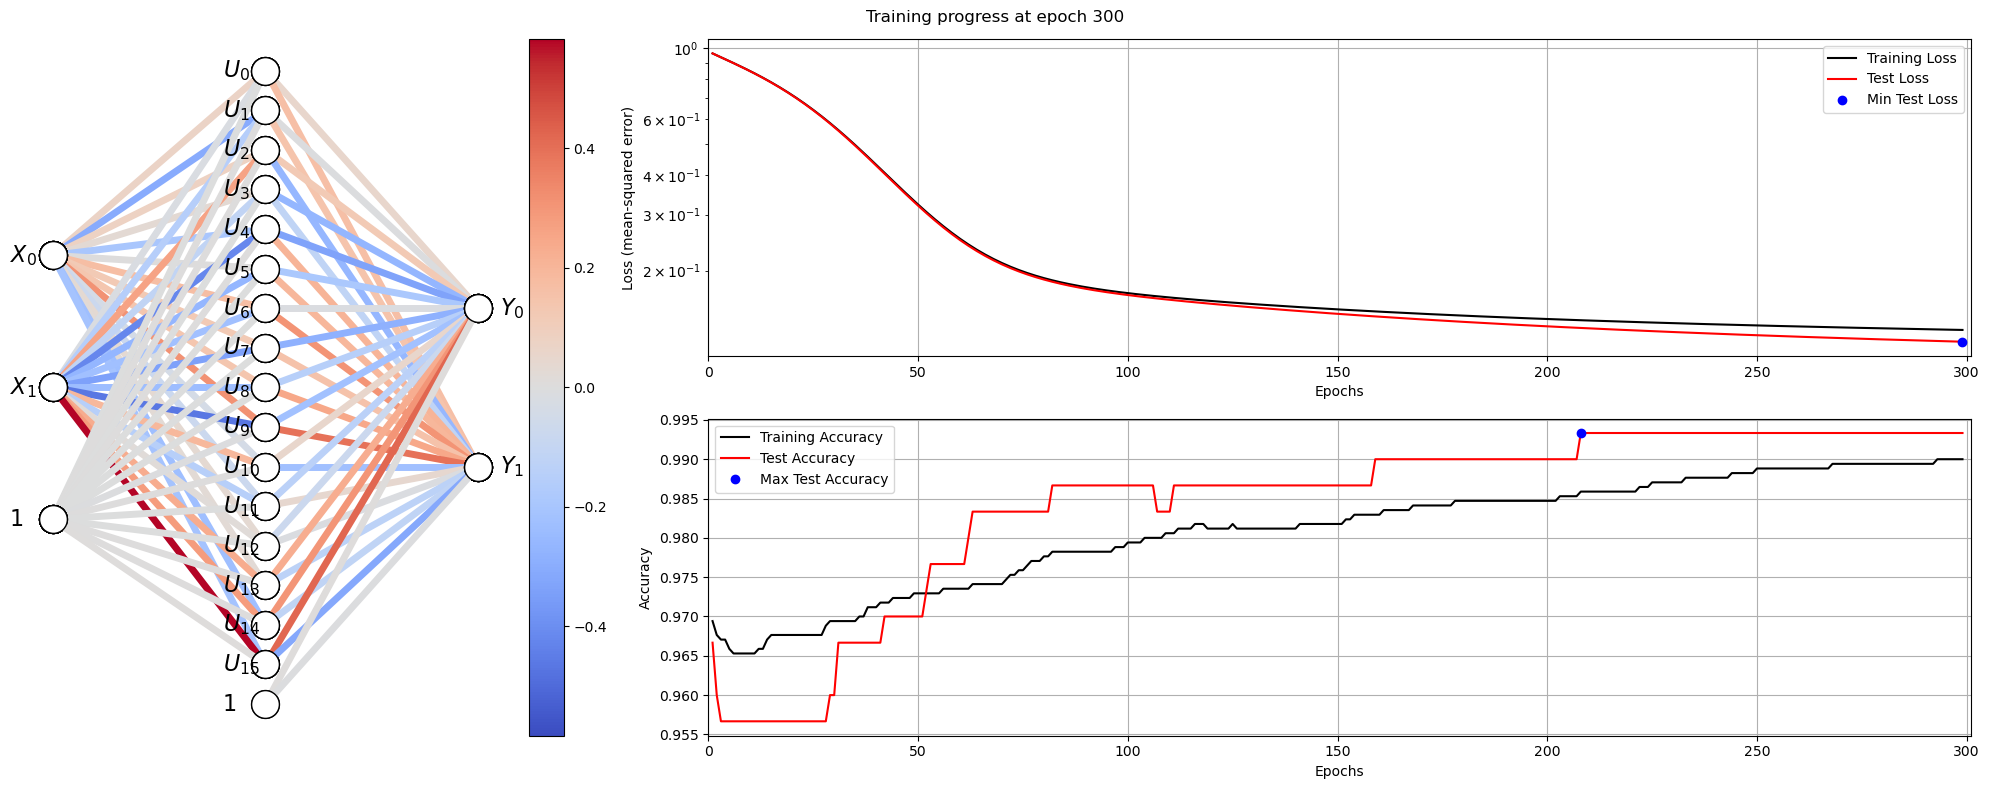

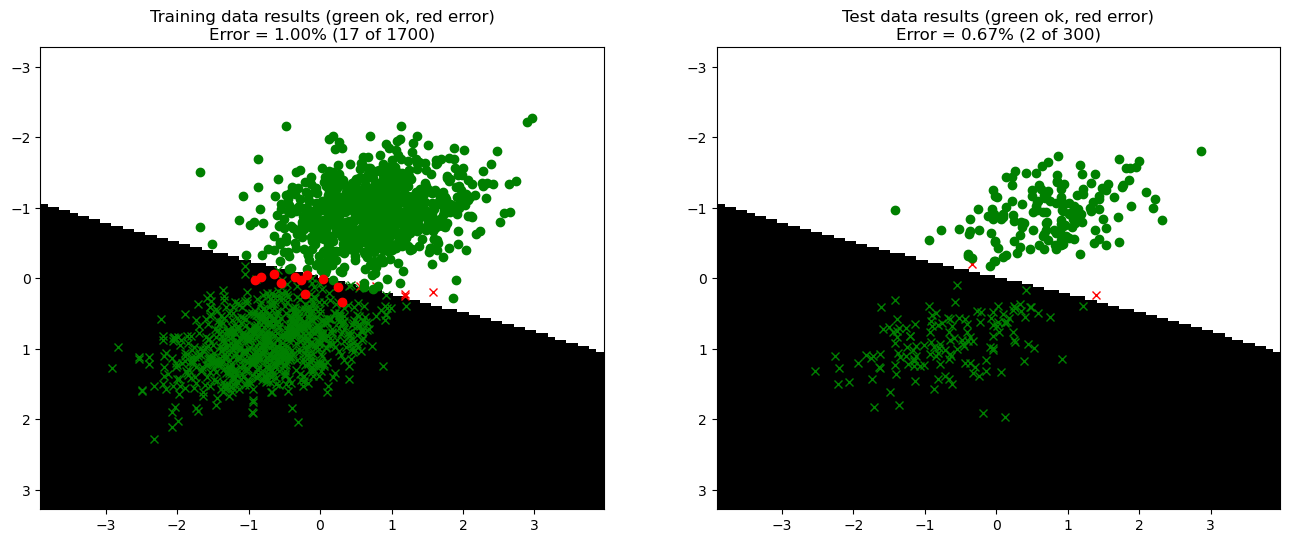

In [43]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

nInputs  = 2
nClasses = 2
nHidden  = 16

W1_0 = np.random.randn(nInputs, nHidden) * 0.1
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.randn(nHidden, nClasses) * 0.1
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 300, "learningRate": 0.01, "normalize": True, "useTanhOutput": False}

# ============================================

trainTwoLayerOnDataset(1, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 2:</span>**

Optimize the model and training hyperparameters until you reach at least 98% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**
Dataset 1

A small hidden layer of 16 neurons is enough for a dataset this simple. I also picked a low learning rate of 0.01 and only 300 epochs because the dataset converges fast. I put normalization on all datasets because it works fine, and there really is no need to have it off. A linear output layer also works good so I turned off tanh for the last layer.

#### **2.2 Optimizing dataset 2**

Train accuracy: 0.9947
Test accuracy: 1.0000
Test data confusion matrix:
[[156   0]
 [  0 144]]


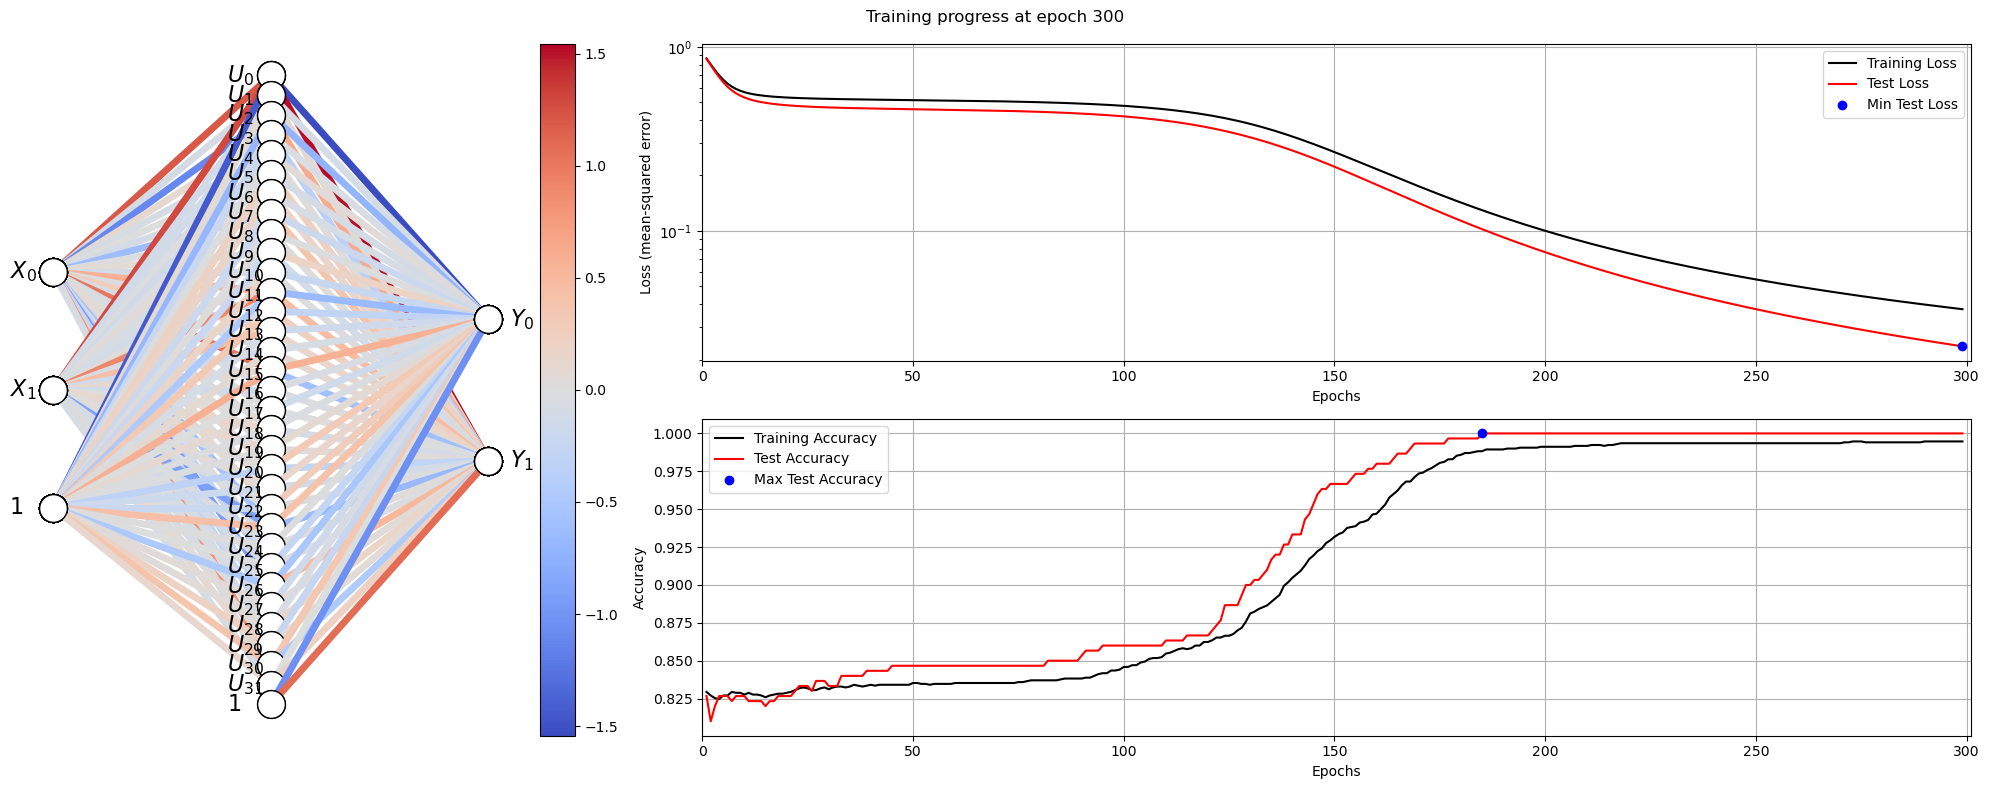

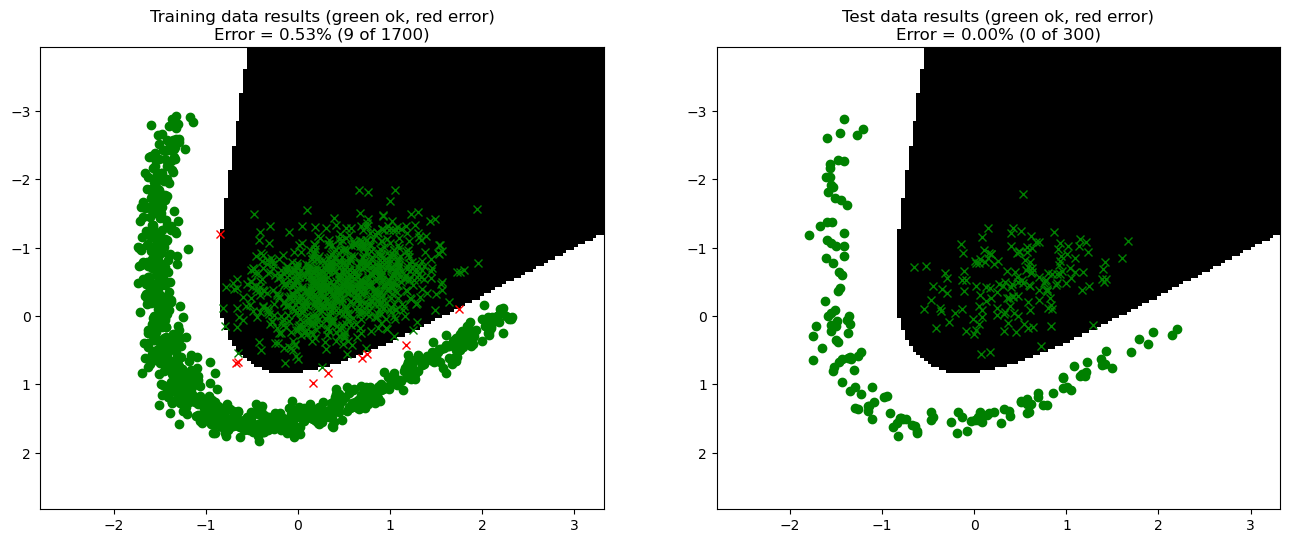

In [42]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

nInputs  = 2
nClasses = 2
nHidden  = 32

W1_0 = np.random.randn(nInputs, nHidden) * 0.1
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.randn(nHidden, nClasses) * 0.1
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 300, "learningRate": 0.1, "normalize": True, "useTanhOutput": True}

# ============================================

trainTwoLayerOnDataset(2, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 3:</span>**

Optimize the model and training hyperparameters until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**
Dataset 2

This dataset is a bit more complex so I upped the number of hidden layer neurons to 32. I also higher the learning rate to 0.1 to speed up convergence, but kept the number of epochs the same. I put tanh on for stabilization, since this was a bit more difficult classification problem.

#### **2.3 Optimizing dataset 3**

Train accuracy: 0.9924
Test accuracy: 1.0000
Test data confusion matrix:
[[100   0   0]
 [  0 110   0]
 [  0   0  90]]


<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

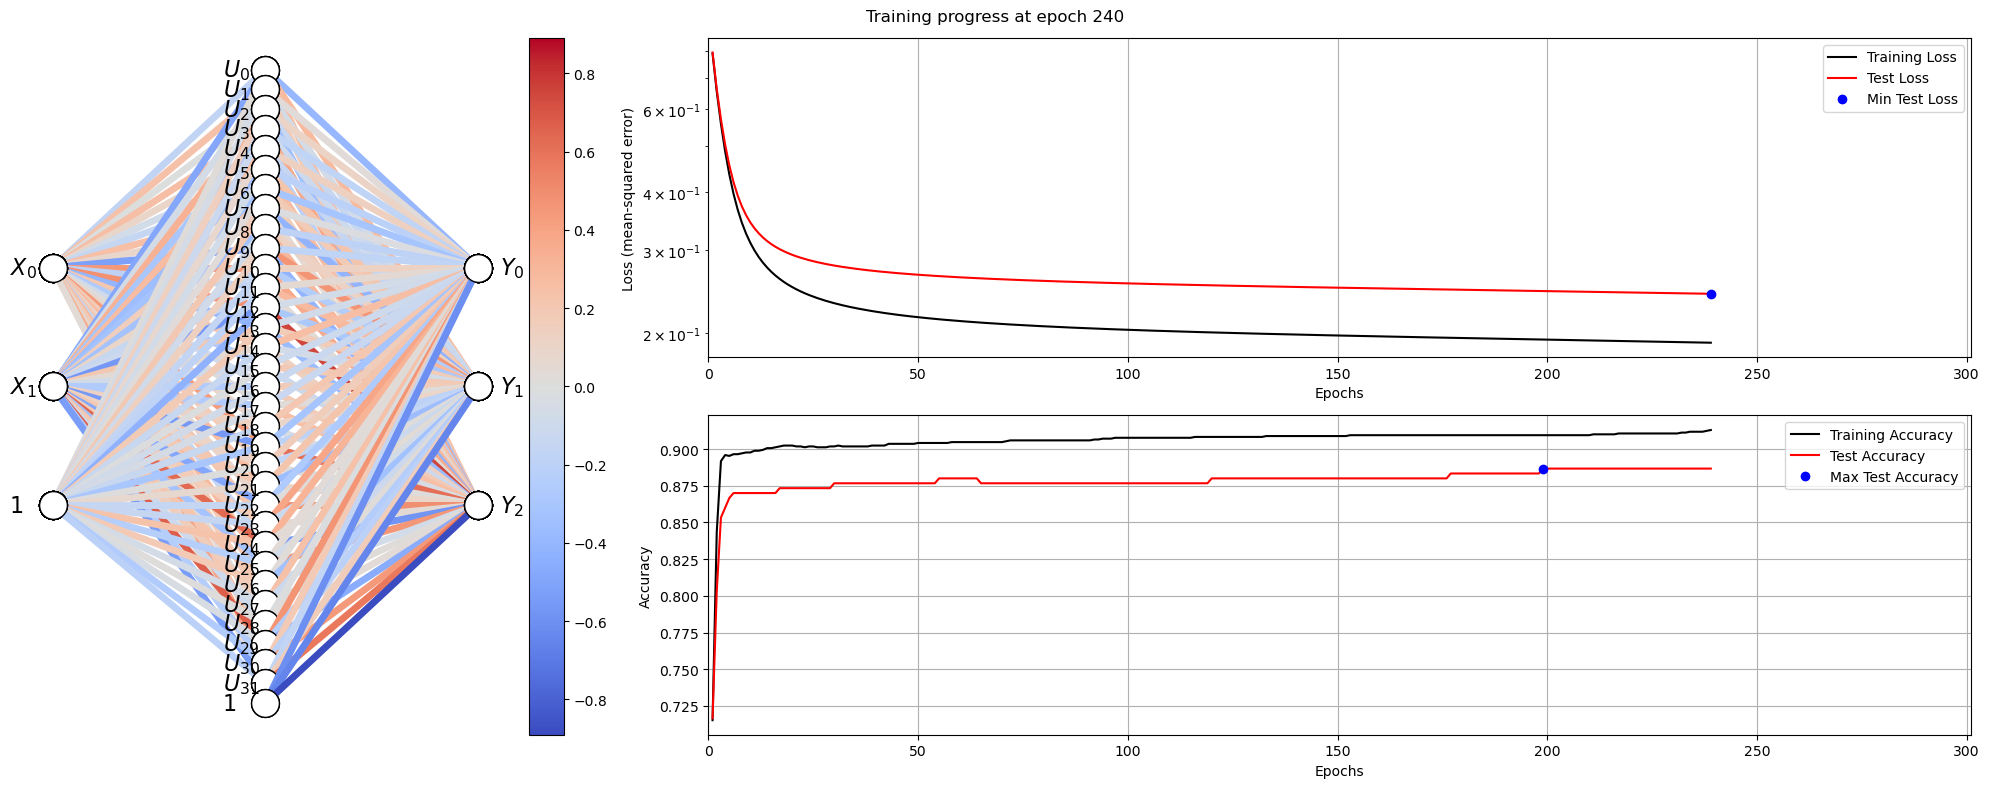

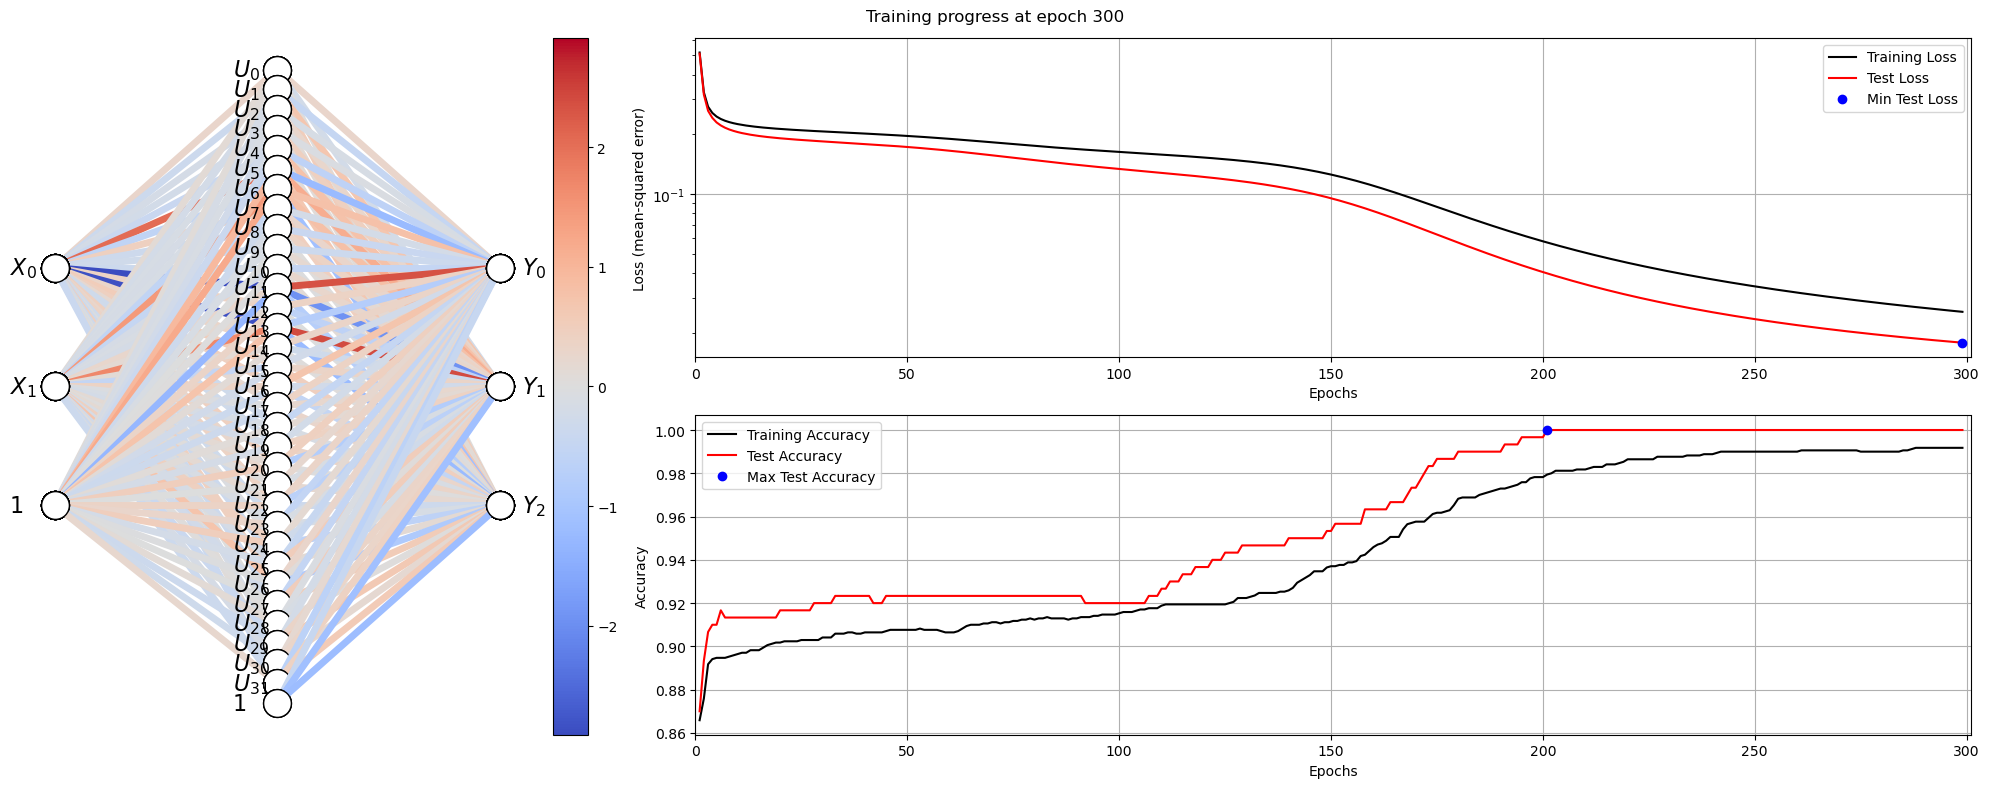

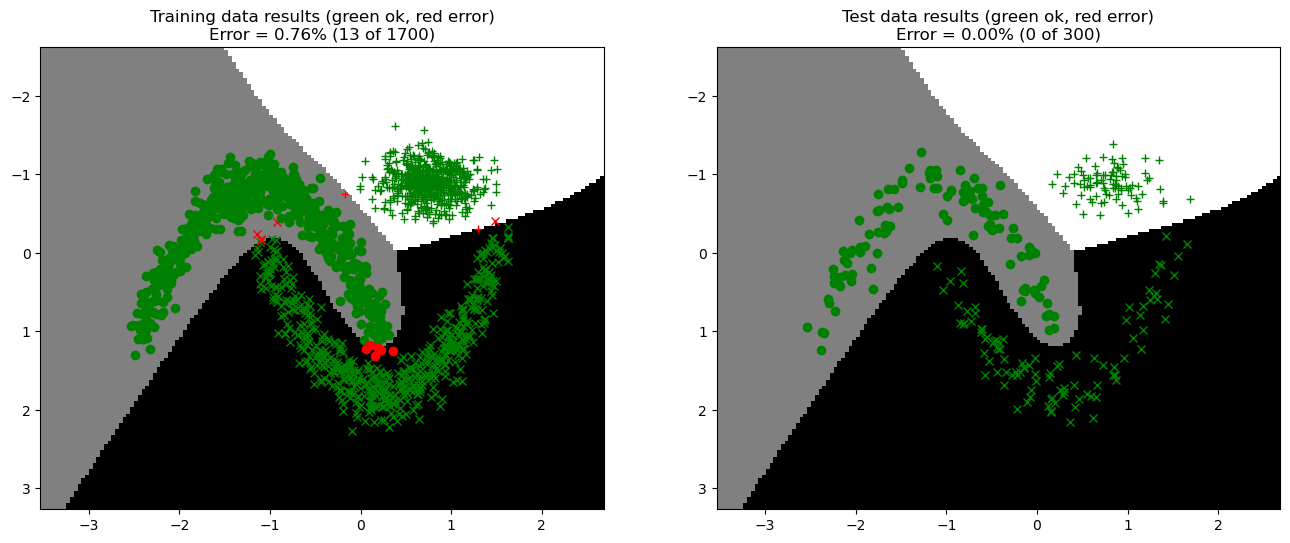

In [38]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

nInputs  = 2
nClasses = 3
nHidden  = 32

W1_0 = np.random.randn(nInputs, nHidden) * 0.1
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.randn(nHidden, nClasses) * 0.1
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 300, "learningRate": 0.5, "normalize": True, "useTanhOutput": True}

# ============================================
trainTwoLayerOnDataset(3, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 4:</span>**

Optimize the model and training hyperparameters until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**
Dataset 3

Same values here as for dataset 2, but I had to increase the learning rate to 0.5 to reach convergence within a reasonable amount of time.

#### **2.4 Optimizing dataset 4**

Train accuracy: 0.9967
Test accuracy: 0.9739
Test data confusion matrix:
[[79  0  0  0  0  0  0  0  0  0]
 [ 0 91  1  0  0  0  0  0  1  0]
 [ 0  0 87  0  0  0  0  0  0  0]
 [ 0  0  1 69  0  0  0  0  0  1]
 [ 0  0  0  0 83  0  1  1  0  1]
 [ 0  0  0  0  0 80  0  0  0  2]
 [ 1  0  1  0  2  0 67  0  0  0]
 [ 0  0  0  0  1  0  0 99  0  0]
 [ 0  0  0  0  1  0  0  0 93  1]
 [ 0  2  0  0  0  3  0  1  0 73]]


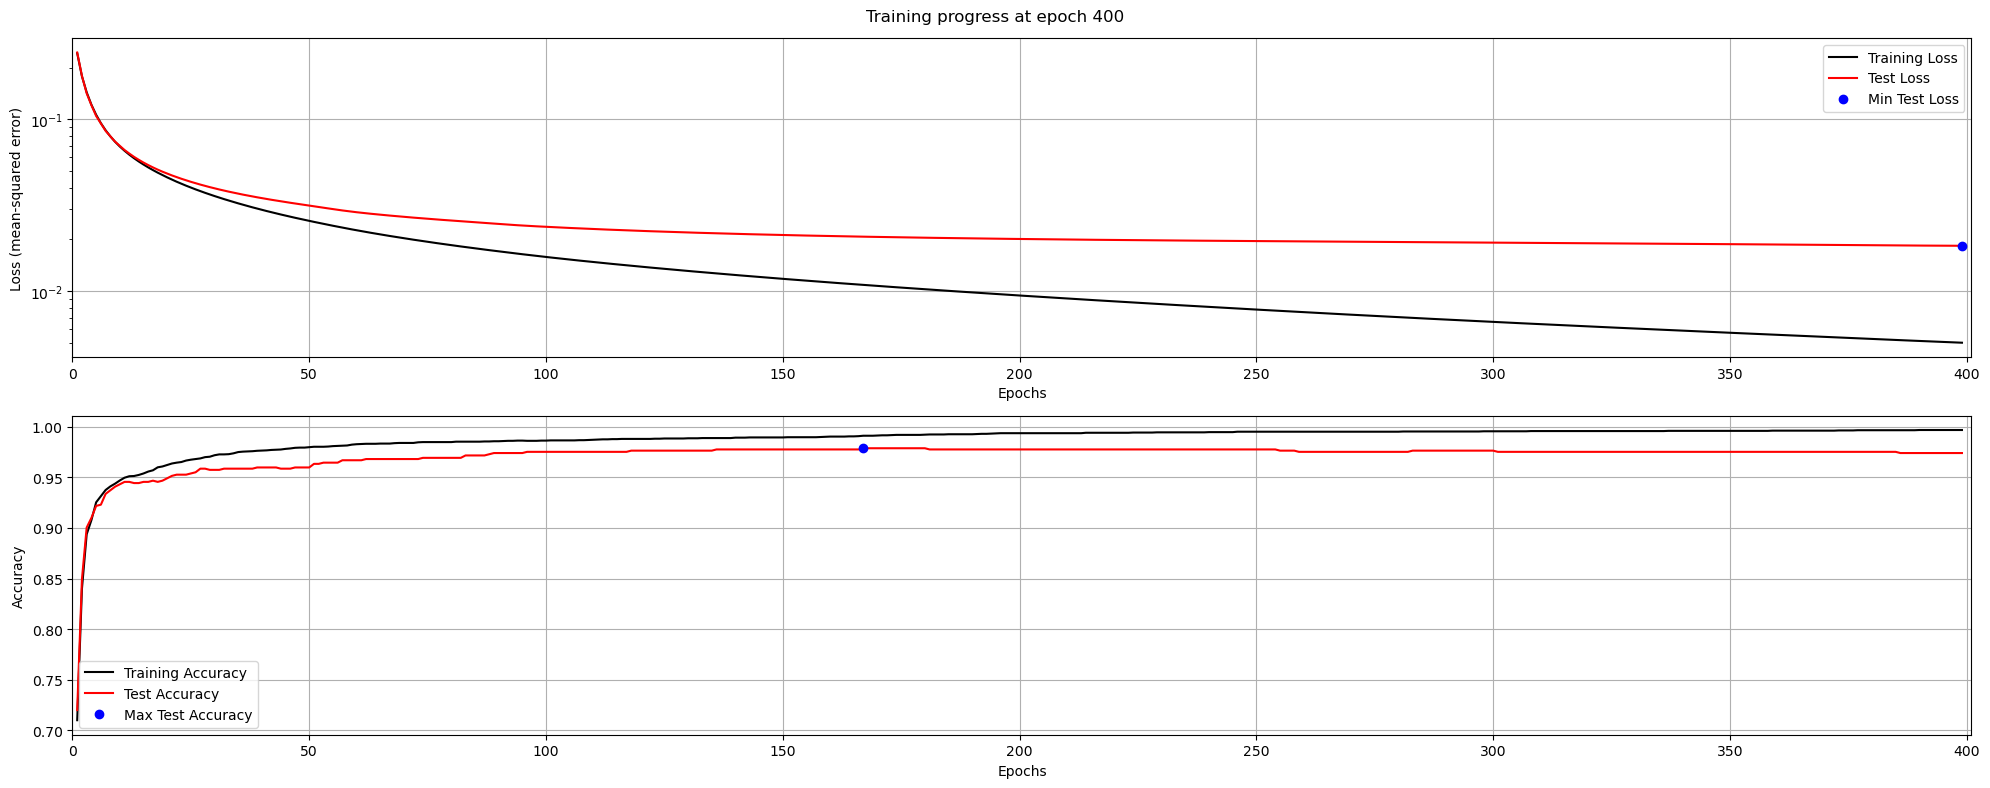

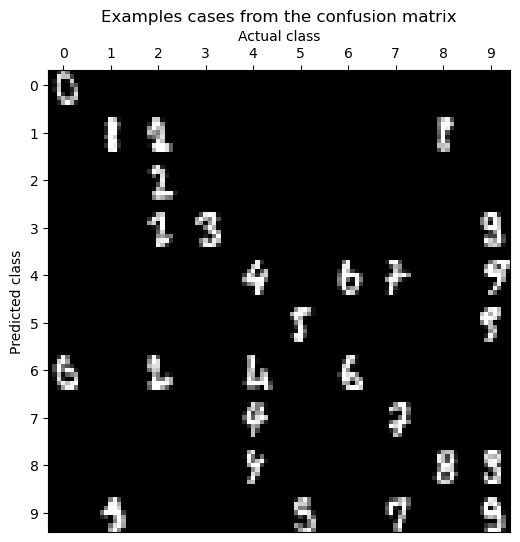

In [44]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

nInputs  = 64
nClasses = 10
nHidden  = 32

W1_0 = np.random.randn(nInputs, nHidden) * 0.1
B1_0 = np.zeros((1, nHidden))
W2_0 = np.random.randn(nHidden, nClasses) * 0.1
B2_0 = np.zeros((1, nClasses))

params = {"epochs": 400, "learningRate": 0.5, "normalize": True, "useTanhOutput": True}

# ============================================

trainTwoLayerOnDataset(4, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 5:</span>**

Optimize the model and training hyperparameters until you reach at least 96% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**
Dataset 4

To handle the handwritten digits I also used 32 neurons in the hidden layer and a learning rate of 0.5 to reach convergence faster. The only thing I changed was increasing the number of epochs up to 400 since data 4 reaches convergence a bit more slowly. 

---
### **3. Optional tasks**

Here are some optional tasks that you can try if you are interested to learn more.

#### **3.1 Tanh output activations**
Implement *tanh* activation in the output layer and re-train the networks in section 2. Do you see any differences in the convergence speed or the decision boundaries?

#### **3.2 Momentum gradient descent**
So far, you have used normal gradient decent without any modifications. This update rule often suffers from a slow convergence speed, and often gets stuck in local minima. There are many more advanced weight update algorithms that try to fix this problem. The most simple upgrade is to use a momentum term that remembers the previous gradients and uses both those and the new to update the weights. In particular, normal gradient descent is defined as

$$ \large W \leftarrow W - \alpha \nabla W $$

with learning rate $\alpha$. Momentum graient descent is instead defined as

$$ \large G_t = \beta G_{t-1} + \alpha \nabla W $$

$$ \large W \leftarrow W - G_t $$

where $\beta$ is called the momentum term. A typical value of $\beta$ is 0.9, which means previous gradients decays exponetially with exponent 0.9. Intuitively, momentum can be though of in the physical sense, where a ball rolling down a hill retains momentum and can therefore get over small bumps in the hill, even if they temporarilly goes upwards. The decay of old gradient can then be thought of as friction. Normal gradient descent has none of these physical intuitions, and will immediately get stuck if it encounters a local minima.

Your task is to change the implementation of `update` and rerun the training. A good showcase of momentum should be dataset 4, which should converge much faster when using $\beta = 0.9$ compared to $\beta = 0$. If you want to go even further after this, you can take a look at [this](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6) blog post which neatly summarizes some of the most common update rules even more powerful than momentum.

#### **3.3 Hyperparameter search**

Manually optimizing the hyperparameters can get tedious, so why not do it automatically? If you have no problems with your computer becomming a heat radiator, an interesting experiment is to implement a grid search over some hyperparameters, for example learning rate, momentum, and size of the hidden layer, and see where the optimal combination is. You probably have to modify the `trainTwoLayerOnDataset` function in two ways to do this.
1. Return the metric you want to optimize, for example the final test loss.
2. Provide a `seed` input to the `splitData` function, to make sure the grid search always uses the same data for each combination of hyper parameters.

#### **3.4 L2 regularization**

You can also try to implement so called L2 regularization, which adds a penalty term to the loss function that penalizes large weights. This is done by adding the term

$$ L_2 = \frac{\lambda}{2} \left( \sum W^2 + \sum V^2 \right)$$

to the loss function, i.e. the scaled sum of all weights, where $\lambda$ is a hyperparameter that controls how strong the penalty is. This will in turn add the term

$$ \nabla L_2 = \large \lambda \left( W + V \right) $$

to the gradient when performing backpropagation. Implement this and see if it improves the performance, especially on dataset 4 which is prone to overfitting due to the large number of parameters.

#### **3.5 Multi-layer network**

As a final optional task, you can try to extend your implementation to support more than two layers. This will require a more general implementation of the forward and backward passes, as well as the weight update, using loops and iterative updates of the gradients as you progress through the layers. The skeleton code is provided in the `MultiLayer.ipynb` notebook.